<div align="center">

# Earth Surface Temperature Analysis
___

## By Joann Balraj
#### January 24, 2021

# Executive Summary

#### Overview & Plan:

I am going to be choosing a major city from the Berkeley Earth temperatures data set.  After preparing and exploring the data, I will use time series forecasting methods to predict average temperatures of Mexico City. After comparing the different forecasting models, I will select the best performing model to run on the test data to predict future temperatures and see how well it performed.   

#### Project Goals:

- Use the earth surface temperature data offered by Berkeley Earth through Kaggle.com. 
- Select one location, could be a city or a state or something relatively similar in size and analyze the patterns in temperature over time. 
- Model those patterns to forecast temperature into the future.

#### Conclusion

- Choosing the city of Mexico in the "Global Land Temperatures by Major City" data set, I acquired, prepped, and explored historical average temperature data to come up with the best forecasting model for predicting average temperatures.
- The Previous Cycle Model was the best model and was able to predict the average temperatures with an RMSE of 1.0
- This model beat out Last Observed Value, Simple Average, Moving Average, and Holt's Linear Trend models.

#### Recommendation & Next Steps:
- Since the existing data set ends with data for 2013, I would recommend adding more updated data to run our forecasting models on.
- I would also continue looking for trends in the data and see how we can adjust our models to better forecast average temperatures for Mexico City.

# Acquire

#### We will obtain data from kaggle:
https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data

In [2]:
### Imports: ###
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import prepare

In [64]:
# This function reads the csv from kaggle, removes data that is not from mexico, drops nulls, and stores it all in a dataframe
df = prepare.get_data()
df.head(1)

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
147847,1835-01-01,13.086,1.942,Mexico,Mexico,20.09N,98.96W


# Prepare & Explore

Choosing Mexico as the city to analyze since it has no null values and has more data than L.A.

In [9]:
df = prepare.prep_data(df)
df.head(1)

,AverageTemperature
ds,
1835-01-01,13.086


### Split the data to use for exploration and modeling

In [10]:
train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
test_size = int(len(df) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

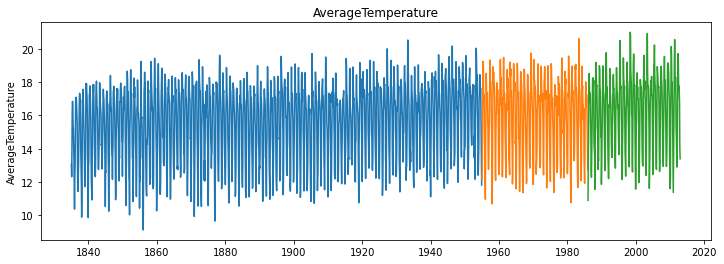

In [61]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

Average Temperature seems to stay pretty steady and follow a cyclical pattern

#### Visualize the Data

Look at the temperature distribution for Mexico City

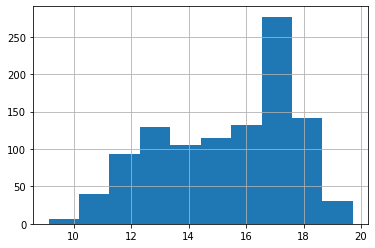

In [12]:
train.AverageTemperature.hist();

It appears the average temperature of Mexico City is about 17

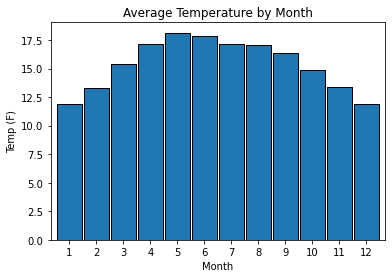

In [13]:
#Store target variable for ease of access
y = train.AverageTemperature

#Plot average temperature by month
ax = y.groupby(y.index.month).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Temperature by Month', xlabel='Month', ylabel='Temp (F)');

It appears that the hottest month in Mexico City is May

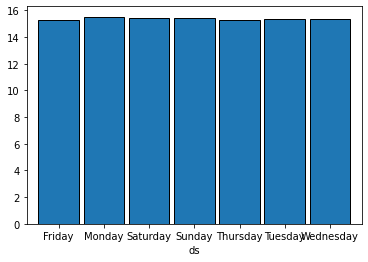

In [14]:
# Plot Average Temperature by Weekday
y.groupby(y.index.day_name()).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Temperature by Weekday', xlabel='Weekday', ylabel='Temp (F)');

It appears that average temperature is pretty much the same for all weekdays

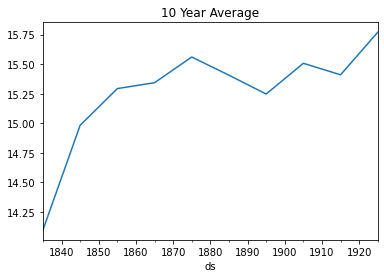

In [17]:
# Plot 10 Year Average Over Time
y.resample('10Y').mean().plot(title='10 Year Average');

The 10 year trend for average temperature appears to be going up



#### Takeaways
- Decided to look at data for Mexico City since it was the most complete (no nulls)
- Only looking at average temperatures for Mexico City so dropped all other columns
- Large data set spans over 150+ years
- May and June are the warmest months
- The average temperature is about the same per weekday
- The 10 year average temperature is trending up

## Model

### First, define functions to aid in evaluating and plotting

In [18]:
# define evaluation function to compute rmse

def evaluate(target_var):
    '''
    the evaluate function will take in the actual values in validate and the predicted values
    and compute the mean_squared_error and then take the square root and round to 0 decimals.
    It will return the rmse, an integer.
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])),0)
    return rmse

In [19]:
# plot and evaluate 

def plot_and_eval(target_var):
    '''
    this function will plot the train, validate, and test values for a single variable 
    across all dates. 
    '''

    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [21]:
# Create the empty dataframe with model_type, target_var, rmse
eval_df = pd.DataFrame(columns = ['model_type', 'target_var', 'rmse'])

In [23]:
# Define function to store rmse for comparison purposes

def append_eval_df(model_type, target_var):
    '''
    this function is going to take in the model_type as a string, the target variable as a string,
    and run the evaluate() function to compute the rmse, and append to the data frame a row
    with the model_type, target_var, and rmse.  It will return the new dataframe.
    '''
    rmse = evaluate(target_var)

    d = {'model_type': [model_type], 'target_var': [target_var],'rmse':[rmse]}
    d = pd.DataFrame(d)
    
    return eval_df.append(d, ignore_index=True)

## Forecast
#### Start creating models to predict future values

### Last Observed Value Model

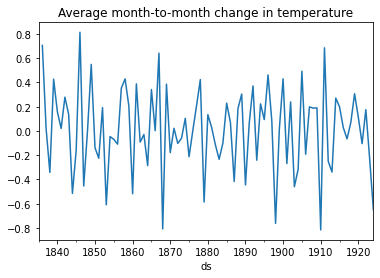

In [24]:
y.resample('Y').mean().diff().plot(title='Average month-to-month change in temperature');

In [25]:
dt = train['AverageTemperature'][-1]
dt

18.226

In [26]:
# make predictions by adding those values to new dataframe yhat_df
yhat_df = pd.DataFrame({'AverageTemperature':[dt]}, index = validate.index)

yhat_df.head(2)

,AverageTemperature
ds,
1924-05-01,18.226
1924-06-01,18.226


AverageTemperature -- RMSE: 3


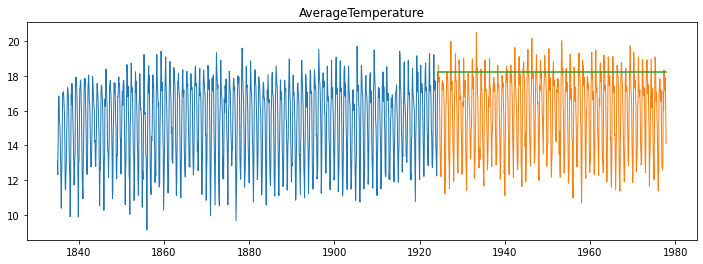

In [27]:
plot_and_eval('AverageTemperature')

Looking at train and validate data with the prediction using Last Observed Value as the model.  It doesn't seem to predict too well as it is just a straight line.

In [28]:
# Evaluate
eval_df = append_eval_df(model_type = 'last_observed_value', target_var = 'AverageTemperature')

eval_df

,model_type,target_var,rmse
0,last_observed_value,AverageTemperature,3.0


### Simple Average

In [29]:
# Simple Average
at = train['AverageTemperature'].mean()
yhat_df = pd.DataFrame({'AverageTemperature':[at]}, index = validate.index)
yhat_df

,AverageTemperature
ds,
1924-05-01,15.36991
1924-06-01,15.36991
1924-07-01,15.36991
1924-08-01,15.36991
1924-09-01,15.36991
...,...
1977-07-01,15.36991
1977-08-01,15.36991
1977-09-01,15.36991


AverageTemperature -- RMSE: 2


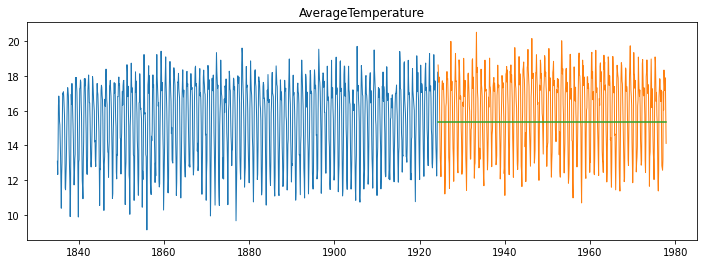

In [30]:
plot_and_eval('AverageTemperature')

Looking at train and validate data with the prediction using Simple Average as the model.  While better than the Last Observed Value model, it doesn't seem to predict too well either as it is just a straight line.

In [31]:
eval_df = append_eval_df(model_type = 'simple_average', target_var = 'AverageTemperature')
eval_df

,model_type,target_var,rmse
0,last_observed_value,AverageTemperature,3.0
1,simple_average,AverageTemperature,2.0


### Moving Average

In [32]:
def make_predictions():
    yhat_df = pd.DataFrame({'AverageTemperature': [AverageTemperature]}
                           , index = validate.index)
    return yhat_df

In [33]:
period = 24
# use the rolling method, take the rolling mean of 24 months, and select the last value, 
# i.e. the last day in train
dt = round(train['AverageTemperature'].rolling(period).mean().iloc[-1], 5)
yhat_df = pd.DataFrame({'AverageTemperature':[dt]}, index = validate.index)
yhat_df

,AverageTemperature
ds,
1924-05-01,15.88504
1924-06-01,15.88504
1924-07-01,15.88504
1924-08-01,15.88504
1924-09-01,15.88504
...,...
1977-07-01,15.88504
1977-08-01,15.88504
1977-09-01,15.88504


AverageTemperature -- RMSE: 2


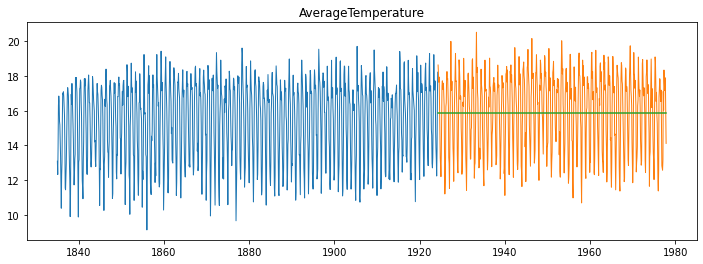

In [34]:
plot_and_eval('AverageTemperature')

Looking at train and validate data with the prediction using Moving Average as the model.  Similar to the Simple Average model, it doesn't seem to predict too well either as it is just a straight line.

In [35]:
eval_df = append_eval_df(model_type = '24month moving average', target_var = 'AverageTemperature')
eval_df

,model_type,target_var,rmse
0,last_observed_value,AverageTemperature,3.0
1,simple_average,AverageTemperature,2.0
2,24month moving average,AverageTemperature,2.0


In [36]:
periods = [60, 90, 120, 150, 180, 365]

for p in periods:
    
    at = round(train['AverageTemperature'].rolling(period).mean().iloc[-1], 5)
    yhat_df = pd.DataFrame({'AverageTemperature':[at]}, index = validate.index)
    model_type = str(p) + ' Month moving average'
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'AverageTemperature')

In [37]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,AverageTemperature,3.0
1,simple_average,AverageTemperature,2.0
2,24month moving average,AverageTemperature,2.0
3,60 Month moving average,AverageTemperature,2.0
4,90 Month moving average,AverageTemperature,2.0
5,120 Month moving average,AverageTemperature,2.0
6,150 Month moving average,AverageTemperature,2.0
7,180 Month moving average,AverageTemperature,2.0
8,365 Month moving average,AverageTemperature,2.0


### Holt's Linear Trend

Looking at the decomposition of the trend, seasonality, and residual error for 3 months at a time, it's difficult to determine a cycle or pattern.

AverageTemperature 



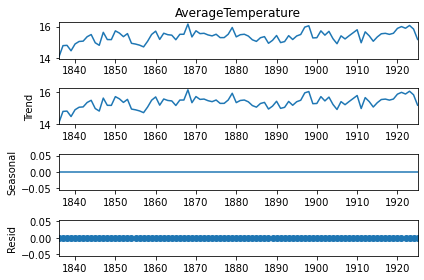

In [38]:
import statsmodels.api as sm

for col in train.columns:
    print(col,'\n')
    _ = sm.tsa.seasonal_decompose(train[col].resample('Y').mean()).plot()
    plt.show()

Looking at the decomposition of the trend, seasonality, and residual error for one year at a time, the trend shows a cycle of ups and downs within 10 year spans. 

In [39]:
for col in train.columns:
    model = Holt(train[col], exponential = False)
    model = model.fit(smoothing_level = .1, 
                      smoothing_slope = .1, 
                      optimized = False)
    yhat_items = model.predict(start = validate.index[0], 
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

In [43]:
yhat_df.head(3)

,AverageTemperature
ds,
1924-05-01,15.49
1924-06-01,15.46
1924-07-01,15.43


AverageTemperature -- RMSE: 12


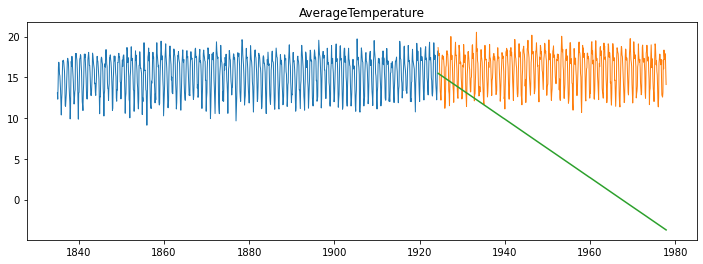

In [42]:
for col in train.columns:
    plot_and_eval(target_var = col)

Looking at the prediction for Holt's linear trend can quickly see it is not a good model as sharply deviates downward away from validate data.

In [44]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'Holts', 
                             target_var = col)
    
eval_df

,model_type,target_var,rmse
0,last_observed_value,AverageTemperature,3.0
1,simple_average,AverageTemperature,2.0
2,24month moving average,AverageTemperature,2.0
3,60 Month moving average,AverageTemperature,2.0
4,90 Month moving average,AverageTemperature,2.0
5,120 Month moving average,AverageTemperature,2.0
6,150 Month moving average,AverageTemperature,2.0
7,180 Month moving average,AverageTemperature,2.0
8,365 Month moving average,AverageTemperature,2.0
9,Holts,AverageTemperature,12.0


Holt's model seems to be performing the worst thus far with an RMSE of 12.0

### Predict on Previous Cycle

In [45]:
train = df[:'1954']
validate = df['1955':'1985']
test = df['1986':'2012']

In [46]:
# Make predictions using average year over year differences for next 30 years based on cycles.
# Adding that average delta to the values during 1924-1954. 
yhat_df = train['1924':'1954'] + train.diff(30*12).mean()

In [47]:
pd.concat([yhat_df.head(1), validate.head(1)])

,AverageTemperature
ds,
1924-01-01,12.520006
1955-01-01,12.164000


In [48]:
# Set yhat_df to index of validate:
# Setting the index in your yhat dataframe to represent the dates those predictions are made for
yhat_df.index = validate.index

AverageTemperature -- RMSE: 1


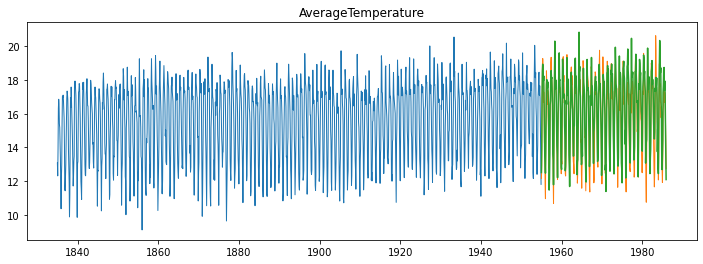

In [49]:
plot_and_eval('AverageTemperature')

This model's prediction against the actual is much better aligned than all other models.

In [52]:
eval_df = append_eval_df(model_type = 'previous cycle', target_var = 'AverageTemperature')

### Comparing and Selecting Best Model

In [53]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,AverageTemperature,3.0
1,simple_average,AverageTemperature,2.0
2,24month moving average,AverageTemperature,2.0
3,60 Month moving average,AverageTemperature,2.0
4,90 Month moving average,AverageTemperature,2.0
5,120 Month moving average,AverageTemperature,2.0
6,150 Month moving average,AverageTemperature,2.0
7,180 Month moving average,AverageTemperature,2.0
8,365 Month moving average,AverageTemperature,2.0
9,Holts,AverageTemperature,12.0


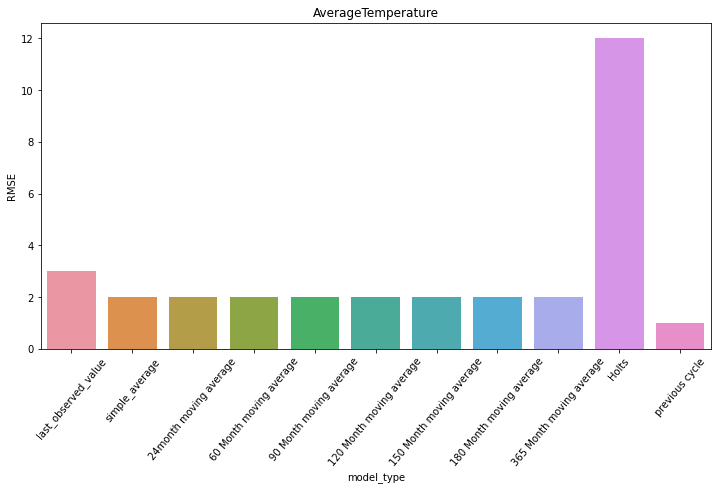

In [56]:
# Plot model comparison
x = eval_df[eval_df.target_var == 'AverageTemperature']['model_type']
y = eval_df[eval_df.target_var == 'AverageTemperature']['rmse']
plt.figure(figsize=(12, 6))
sns.barplot(x, y)
plt.title(col)
plt.ylabel('RMSE')
plt.xticks(rotation=50)
plt.show()

#### Takeaways

- The Holt's model performed the worst.

- The Previous Cycle Model performed best with an RMSE of 1.0.

- Will be using Previous Cycle model to predict on test.
***

# Predict on Test

### Let's test our best model out on our out-of-sample data

- We will be using Previous Cycle Model to predict test.

In [57]:
# Make predictions on test using Previous Cycle model using validate + train
yhat_df2 = validate['1959':'1985'] + train.diff(30*12).mean()
yhat_df2.index = test.index

# Make predictions for the future past our existing data
yhat_df3 = test['1986':'2012'] + train.diff(30*12).mean()
yhat_df3.index = test.index + pd.Timedelta('27Y')

rmse_avgtemp = round(sqrt(mean_squared_error(test['AverageTemperature'], yhat_df2['AverageTemperature'])), 2)

# Showing RMSE of our model 
print("rmse - Average Temperature: ", rmse_avgtemp)

rmse - Average Temperature:  1.0


#### Our model performed the same as on validate data with an RMSE of 1.0 proving it is a good model. 

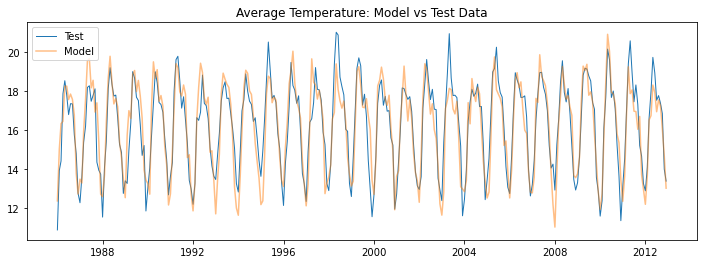

In [58]:
# Look at how our model prediction stood against the actual test data

target_var = "AverageTemperature"
plt.figure(figsize = (12,4))
plt.plot(test[target_var], label = 'Test', linewidth = 1)
plt.plot(yhat_df2[target_var], label = 'Model', alpha = .5)
plt.title("Average Temperature: Model vs Test Data")
plt.legend()
plt.show()

Looking at how our best model fared against the actual test data, we can see that it does well predicting the average temperature.

In [59]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(test[target_var], label = 'Test', linewidth = 1)
    plt.plot(yhat_df3[target_var],label = 'Prediction', alpha = .5)
    plt.title('Average Temperatures of Mexico City Over Time with Future Predictions')
    plt.legend(loc='upper left')
    plt.show()

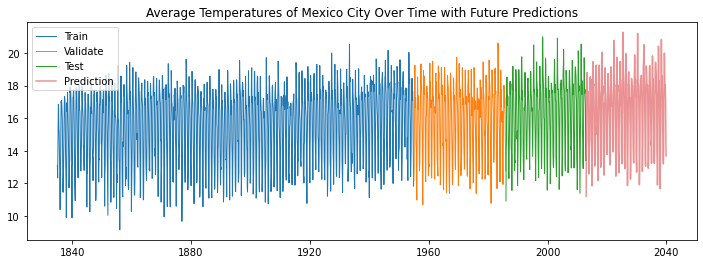

In [60]:
plot_and_eval('AverageTemperature')

The plot showing future predictions for average temperatures past 2012 (and past our data set), shows that it could be a reasonable predictor of average temperatures.
___



### Conclusion:
- Choosing the city of Mexico in the "Global Land Temperatures by Major City" data set, I acquired, prepped, and explored historical average temperature data to come up with the best forecasting model for predicting average temperatures.


- The Previous Cycle Model performed well with a final RMSE of 1.0
- The Previous Cycle Model outperformed the Simple Average, Moving Average, Last Observed Value, and Holt's Linear Trend Models
- Predictions were made for future average temperatures for Mexico City and they look to align well with previous data (as seen in red on the plot above).

#### Recommendation & Next Steps:
- Since the existing data set ends with data for 2013, I would recommend adding more updated data to run our forecasting models on.
- I would also continue looking for trends in the data and see how we can adjust our models to better forecast average temperatures for Mexico City.